In [1]:
import numpy as np 
import pandas as pd 
import pymc as pm 
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data: U.S. Single-Family Home Sales

In [2]:
home_sales = pd.read_csv("home_sales_us.csv")
home_sales['observation_date'] = pd.to_datetime(home_sales['observation_date'])

In [3]:
home_sales.head()

,observation_date,HSN1F
0,1963-01-01,591
1,1963-02-01,464
2,1963-03-01,461
3,1963-04-01,605
4,1963-05-01,586


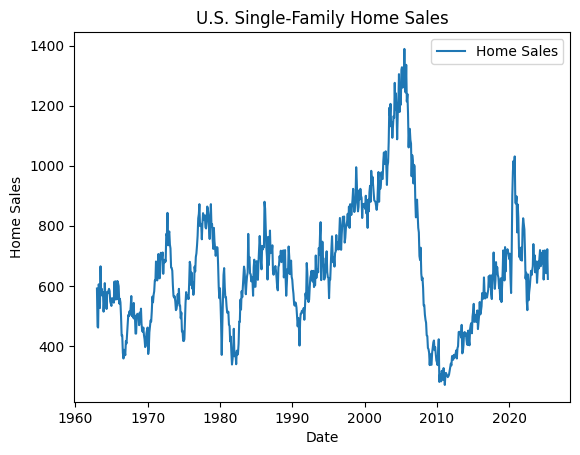

In [4]:
plt.plot(home_sales['observation_date'], home_sales['HSN1F'], label='Home Sales')
plt.xlabel('Date')
plt.ylabel('Home Sales')
plt.title('U.S. Single-Family Home Sales')
plt.legend()

In [5]:
split_index = int(len(home_sales) * 0.8)
train_data = home_sales.iloc[:split_index]
test_data = home_sales.iloc[split_index:]
scaler = StandardScaler()
y_train = scaler.fit_transform(train_data['HSN1F'].values.reshape(-1, 1)).flatten()
y_test = scaler.transform(test_data['HSN1F'].values.reshape(-1, 1)).flatten()

# Model

$$ y_t = g(t) + s(t) + \varepsilon_t$$ 

where $g(t)$ models the trend compoenent, $s(t)$ describes seaonsality and $\varepsilon_t$ is is a white noise error term. More specifically, $g(t)$ is a piecewise-linear function with change points
$$ g(t) = \alpha(t) + \beta(t)t$$
where, 
\begin{align*}
\alpha(t) &= \alpha_0 + \sum_{j=1}^{k} (-s_j A_{tj}) \cdot \delta_j \\ 
\beta(t) &= \beta_0 + \sum_{j=1}^{k} A_{tj} \cdot \delta_j
\end{align*}
with $A_{tj} = \mathbb{1}\{t > s_j\}$, $s_j$ denote change-point locations evenly spaced across the time series, $\delta_j \sim \mathcal{N}(0, 1)$ are changepoint adjustments to the slope, and $\alpha_0 \sim \mathcal{N}(0, 1)$, $\beta_0 \sim \mathcal{N}(0, 1)$, are priors on intercept and slope. 

The seasonal component is modeled using a Fourier series

$$s(t) = \sum_{n=1}^N \left[ a_n \cos\left( \frac{2\pi n t}{p} \right) + b_n \sin\left( \frac{2\pi n t}{p} \right) \right]  \implies s(t) = \mathbf{X}_t^\top \boldsymbol{\beta}, \quad \boldsymbol{\beta} \sim \mathcal{N}(0, 1)$$

Where $\mathbf{X}_t$ is a design matrix of Fourier basis functions with $2N$ columns (cos and sin terms) and $p$ is the seasonal period (e.g., 12 for monthly seasonality).

Instead of Gaussian nosie, the model assumes 

$$\varepsilon_t \sim \text{StudentT}(\nu, 0, \sigma) \\
\sigma \sim \text{Exponential}(1) \\
\nu \sim \text{Exponential}(0.1): 
$$

Thus, 

$$

y_t \sim \text{StudentT}(\nu, \mu_t, \sigma)\\

\mu_t = \alpha(t) + \beta(t)t + \mathbf{X}_t^\top \boldsymbol{\beta}

$$



In [6]:
def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)
    
    return A, s, X

In [7]:
t = np.arange(len(y_train))
t_max = max(t)

changepoints = 25
with pm.Model() as prophet_model:
    t_pt = pm.MutableData('t', t)
    A, s, X = generate_features(t_pt, t_max, n_changepoints=changepoints, n_fourier=12, p=12)
    
    initial_slope = pm.Normal('initial_slope')
    initial_intercept = pm.Normal('initial_intercept')
    
    # n_changepoint offsets terms to build the peicewise trend
    deltas = pm.Normal('offset_delta', shape=(changepoints,))
        
    intercept = initial_intercept + ((-s * A) * deltas).sum(axis=1)
    slope = initial_slope + (A * deltas).sum(axis=1)
    
    # n_fourier * 2 seasonal coefficients
    beta = pm.Normal('beta', size=24)
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt + X @ beta)
    #sigma = pm.Exponential('sigma', 1)

    #y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=scaled_sales, shape=t_pt.shape)
    sigma = pm.Exponential('sigma', 1)
    nu = pm.Exponential('nu', 1 / 10)  # Degrees of freedom (low nu => heavy tails)
    
    y_hat = pm.StudentT('y_hat', mu=mu, sigma=sigma, nu=nu, observed=y_train, shape=t_pt.shape)
    
    idata = pm.sample(nuts_sampler="numpyro", draws=1000, tune=1000, chains=2, return_inferencedata=True)

/Users/stevenfiore/Projects/Timeseries/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running chain 0: 100%|██████████| 2000/2000 [01:50<00:00, 18.08it/s]
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
with prophet_model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    last_t = t[-1]
    
    # Forecast 3 years of home sales
    forecast_t = np.arange(last_t, len(home_sales))
    pm.set_data({'t':forecast_t})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Sampling: [y_hat]


In [9]:
def plot_results(idata, test_data=None, oos_name='Test', date_index=None):
    import matplotlib.dates as mdates

    fig, ax = plt.subplots(figsize=(12, 6))

    def get_var(group_name):
        group = getattr(idata, group_name, None)
        if group and group.data_vars:
            var = list(group.data_vars.keys())[0]
            return group[var]
        return None

    # Handle time index
    def get_time_range(start_idx, length):
        if date_index is not None:
            return date_index[start_idx:start_idx + length]
        else:
            return np.arange(start_idx, start_idx + length)

    x_train_len = 0

    # Plot observed data
    obs = get_var('observed_data')
    if obs is not None:
        y_obs = obs.values
        x_vals = get_time_range(0, len(y_obs))
        ax.plot(x_vals, y_obs, color='black', label='Observed Data')
        x_train_len = len(y_obs)

    # Plot posterior predictive
    post_pred = get_var('posterior_predictive')
    if post_pred is not None:
        mean = post_pred.mean(dim=['chain', 'draw']).values
        x_vals = get_time_range(0, len(mean))
        ax.plot(x_vals, mean, color='blue', label='Posterior Predictive')
        try:
            hdi = az.hdi(post_pred, hdi_prob=0.9)
            lower = hdi.sel(hdi="lower").y_hat.values
            upper = hdi.sel(hdi="higher").y_hat.values
            ax.fill_between(x_vals, lower, upper, color="blue", alpha=0.25)
        except:
            pass

    # Plot predictions
    pred = get_var('predictions')
    if pred is not None:
        mean = pred.mean(dim=['chain', 'draw']).values[1:]
        x_vals = get_time_range(x_train_len, len(mean))
        ax.plot(x_vals, mean, color='green', label=f'{oos_name} Predictions')
        try:
            hdi = az.hdi(pred, hdi_prob=0.9)
            lower = hdi.sel(hdi="lower").y_hat.values[1:]
            upper = hdi.sel(hdi="higher").y_hat.values[1:]
            ax.fill_between(x_vals, lower, upper, color="blue", alpha=0.25)
        except Exception as e:
            print(f"Failed to plot HDI: {e}")
        if test_data is not None and len(test_data) == len(x_vals):
            ax.plot(x_vals, test_data, color='black', linestyle='--', label=f'True {oos_name} Data', markersize=4)

    # Axis formatting
    if date_index is not None:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=60))
        fig.autofmt_xdate()

    ax.set_xlabel('Date' if date_index is not None else 'Time')
    ax.set_ylabel('Value')
    ax.set_title('Model Results')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

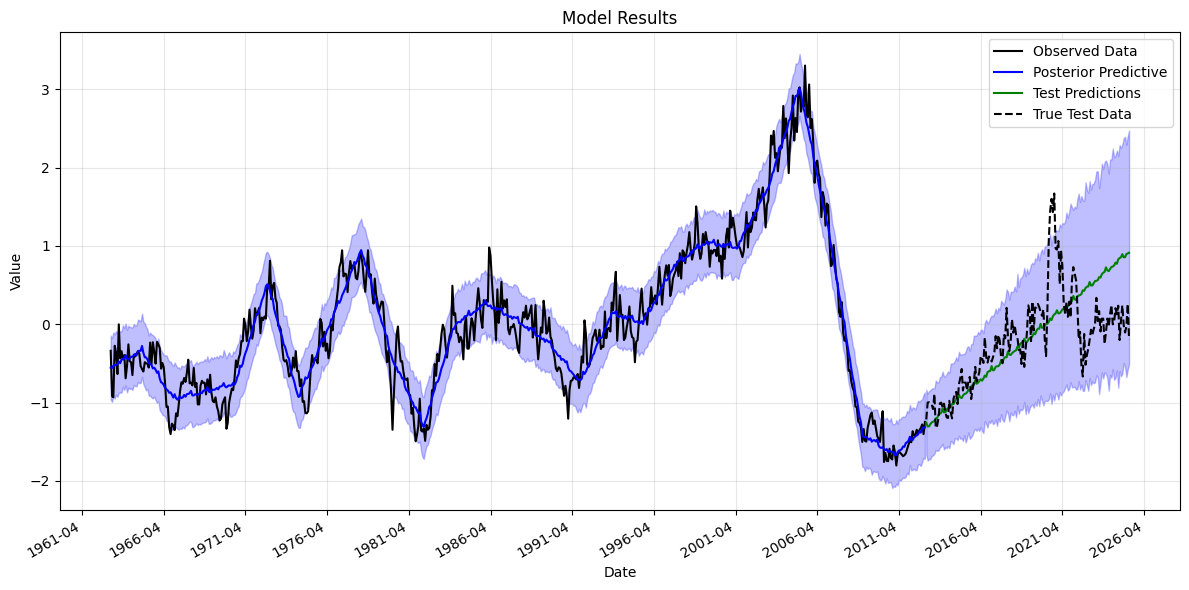

In [10]:
plot_results(idata, test_data=y_test, oos_name='Test', date_index=home_sales['observation_date'].values)